## PRE-EXPERIMENT #2 - TENSORFLOW BERT CLASSIFICATION APPROACH FOR THE GOLF COURSE REVIEW DATA

In this file, we will be experimenting with the Tensorflow BERT model to create an end-to-end BERT
classification model for the expanded golf course review dataset. In this experiment, we will be
completing both the embedding creation and the classification model using BERT.

----

**1. Import the necessary libraries for this experiment**

In [ ]:
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

In [3]:
import pandas as pd
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

**2. Load the expanded golf course review dataset**

In [4]:
# Load the dataset
file_path = "top_and_non_golf_course_reviews.csv"
df = pd.read_csv(file_path)

**3. Preprocess the dataset**

For data prepprocessing, we will be using the following steps:

- Tokenization
- Non-alphabetic token removal
- Stopword removal
- Lemmatization
- Domain-specific stopword removal


In [9]:
import nltk
nltk.download('stopwords')
import spacy
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Load necessary NLP models and stopwords that will be used for data preprocessing
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])   # Load the spaCy English language model, disable the parser and named entity recognition for efficiency
standard_stop_words = set(stopwords.words('english'))   # Load the English stopwords from NLTK
tokenizer = RegexpTokenizer(r'\w+')   # Define a regular expression tokenizer to remove and punctuation and perform tokenization using NLTK's RegexpTokenizer
domain_specific_stopwords = set([
    'course', 'play', 'hole', 'green', 'par', 'tee', 'yard', 'golf', 'one', 'bunker', 'fairway', 'leave', 'shot', 'right', 'good', 'club'
])

# Define a function to preprocess the text data
def preprocess_text(text):
    """
    Preprocesses a single document by applying several preprocessing steps:
        - Tokenization
        - Removal of non-alphabetic tokens and tokens with less than 3 characters
        - Conversion to lowercase
        - Removal of stopwords
        - Removal of domain-specific stopwords
        - Lemmatization
    Args:
        text (str): The original text of the golf course review to be preprocessed
    Returns:
        str: The preprocessed text of the golf course review
    """
    # Tokenize the text and convert it to lowercase
    tokens = [token.lower() for token in tokenizer.tokenize(text) if token.isalpha() and len(token) > 2]
    # Remove stopwords and domain-specific stopwords
    tokens = [token for token in tokens if token not in (standard_stop_words | domain_specific_stopwords)]
    # Lemmatize the tokens
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc if token.lemma_ not in standard_stop_words]
    # Return the preprocessed text as a single string
    return " ".join(tokens)

# Apply the preprocessing function to the 'review_text' column of the df DataFrame
df['cleaned_review_text'] = df['review_text'].apply(preprocess_text)

# Create a new 'top100' column to indicate whether the course is ranked in the top 100
df['top100'] = df['label'].apply(lambda x: 1 if x == 'top100' else 0)

# Display the first few rows of the DataFrame with the cleaned review text
df[['review_text', 'cleaned_review_text', 'label', 'top100']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,review_text,cleaned_review_text,label,top100
0,There’s not much point trying to do a hole-by-...,much point try guide pine valley since much we...,top100,1
1,What to Expect: Pine Valley is the finest gol...,expect pine valley fine planet hold royal flus...,top100,1
2,“No one but a poet should be allowed to write ...,poet allow write beauty cypress point samuel m...,top100,1
3,What to Expect: I don't even feel worthy to w...,expect even feel worthy write review cypress p...,top100,1
4,"There’s not many courses as acclaimed, sought ...",many course acclaim seek document shinnecock h...,top100,1


**4. Split the dataset into training, validation, and testing sets**

In [10]:
from sklearn.model_selection import train_test_split
# First Split: 70% training, the remaining 30% for validation and testing
train_df, remaining = train_test_split(df, test_size=0.3, stratify=df['top100'], random_state=42)

# Second Split: 50% of the remaining data for validation, the other 50% for testing
val_df, test_df = train_test_split(remaining, test_size=0.5, stratify=remaining['top100'], random_state=42)

# Check the shape of the training, validation, and test sets
print(f"Training Dataset Shape: {train_df.shape}")
print(f"Validation Dataset Shape: {val_df.shape}")
print(f"Test Dataset Shape: {test_df.shape}")

Training Dataset Shape: (84, 12)
Validation Dataset Shape: (18, 12)
Test Dataset Shape: (18, 12)


**5. Create Tensorflow Dataset**

We will define the function `create_dataset` to create a Tensorflow Dataset from the cleaned review text and label columns of the dataframe.

The function is used to create three Tensorflow Datasets (train_ds,  val_ds, and test_ds) from the respective subsets of the cleaned review text and label columns.

In [11]:
def create_dataset(dataframe, shuffle=True, batch_size=32):
    """
    Create a TensorFlow Dataset from the cleaned review text and label columns of the given dataframe.

    Args:
        dataframe (pandas.DataFrame): The dataframe containing the cleaned review text and label columns.
        shuffle (bool, optional): Whether to shuffle the dataset. Defaults to True.
        batch_size (int, optional): The batch size for the dataset. Defaults to 32.

    Returns:
        tf.data.Dataset: The TensorFlow Dataset created from the dataframe.
    """
    ds = tf.data.Dataset.from_tensor_slices((dataframe['cleaned_review_text'].values, dataframe['top100'].values))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Create the Tensorflow Datasets
train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)

**6. Load the BERT pre-processing model and encoder**

Pre-processing model:
- We are using a bert_en_uncased preprocessing module for the BERT model.
- This is used to pre-process the input text data, which will include tokenization,
  conversion to lowercase, and generation of special tokens, like [CLS] and [SEP]--
  which are required for the BERT model.

Encoder:
- We are also using a bert_en_uncase encoder module for the BERT model.
- This is used to take the pre-processed input text data and generate contextualized
  representations for the input text.
- As indicated by L-12_H-768_A-12, this model has 12 layers, a hidden size of 768, and
  an attention head size of 12.

In [12]:
# Define the BERT pre-processing model and the encoder
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

# Load the BERT pre-processing model and the encoder
preprocessor = hub.KerasLayer(tfhub_handle_preprocess)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)

**7. Create the BERT Classification Modle**

In [13]:
def build_classifier_model():
    """
    Builds a classifier model using BERT for text classification.

    Returns:
        tf.keras.Model: The built classifier model.

    This function builds a classifier model using BERT for text classification. It takes in a string input
    and preprocesses it using the BERT preprocessing model. Then, it encodes the preprocessed input
    using the BERT encoder. The encoded output is passed through a dropout layer and a dense layer with
    a single output unit. The output of the dense layer is the final output of the classifier model.

    The input to the model is a string tensor of shape `(None,)`, where `None` represents the batch size.
    The output of the model is a tensor of shape `(None, 1)`, where `None` represents the batch size.

    Note:
        - The BERT preprocessing model and encoder are loaded from the specified URLs.
        - The dropout layer has a dropout rate of 0.1.
        - The dense layer has a single output unit with no activation function.
    """
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [14]:
# Create the classifier model and print its summary
classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

Take a look at the model's structure

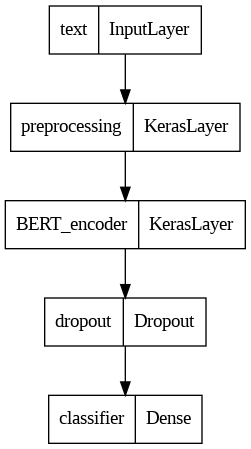

In [15]:
tf.keras.utils.plot_model(classifier_model)

**8. Compile the modle**

**Loss function**

In [19]:
# Define the loss function and the metrics that the model will be evaluated on
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

# Define the number of epochs to train the model on
epochs = 10

# Calculate the number of steps per epoch and the number of training steps
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

# Define the optimizer and it's learning rate
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# Compile the model with the defined loss function, optimizer, and metrics
classifier_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


**9. Train the model**

In [20]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/10
3/3 [==============================] - 46s 12s/step - loss: 0.5774 - binary_accuracy: 0.6905 - val_loss: 0.6917 - val_binary_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 34s 11s/step - loss: 0.5040 - binary_accuracy: 0.8333 - val_loss: 0.7368 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 35s 11s/step - loss: 0.4554 - binary_accuracy: 0.7857 - val_loss: 0.7936 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 34s 11s/step - loss: 0.3840 - binary_accuracy: 0.9167 - val_loss: 0.9244 - val_binary_accuracy: 0.5556
Epoch 5/10
3/3 [==============================] - 34s 11s/step - loss: 0.2453 - binary_accuracy: 0.9524 - val_loss: 0.7732 - val_binary_accuracy: 0.6111
Epoch 6/10
3/3 [==============================] - 34s 11s/step - loss: 0.2376 - binary_accuracy: 0.9048 - val_loss: 0.7387 - val_binary_accuracy: 0.6111
Epoch 7/10
3/3 [==============================] - 34s 11s/step - loss: 0.1536 - bi

In [21]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 2s 2s/step - loss: 0.7720 - binary_accuracy: 0.6111
Loss: 0.7720147371292114
Accuracy: 0.6111111044883728
